## Human Trimmed Dataset

### Obtaining the dataset

Samples collected from 'ERR188204','ERR188258','ERR188317','ERR188453' . The reads are 76 nt long. Each of the reads are trimmed to obtain 50 nt long reads using the following commands. 

```

seqkit subseq -r 1:-27 fastq/ERR188204_1.fastq.gz | gzip - > fastq_clipped/ERR188204_1.50.fastq.gz
seqkit subseq -r 1:-27 fastq/ERR188204_2.fastq.gz | gzip - > fastq_clipped/ERR188204_2.50.fastq.gz
seqkit subseq -r 1:-27 fastq/ERR188258_1.fastq.gz | gzip - > fastq_clipped/ERR188258_1.50.fastq.gz                seqkit subseq -r 1:-27 fastq/ERR188258_2.fastq.gz | gzip - > fastq_clipped/ERR188258_2.50.fastq.gz
seqkit subseq -r 1:-27 fastq/ERR188317_1.fastq.gz | gzip - > fastq_clipped/ERR188317_1.50.fastq.gz
seqkit subseq -r 1:-27 fastq/ERR188317_2.fastq.gz | gzip - > fastq_clipped/ERR188317_2.50.fastq.gz                seqkit subseq -r 1:-27 fastq/ERR188453_1.fastq.gz | gzip - > fastq_clipped/ERR188453_1.50.fastq.gz
seqkit subseq -r 1:-27 fastq/ERR188453_2.fastq.gz | gzip - > fastq_clipped/ERR188453_2.50.fastq.gz

```

For Salmon quantification, alignment, terminus grouping, and mmcollapse grouping the same commands found in `Plots_Related_To_Human_Simulated_4x4_Dataset.ipynb` are used. The salmon quant on the untrimmed dataset are regarded as ground truth while the estimates on trimmed dataset are being compared.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys
import readBootstraps
from collections import defaultdict

In [8]:
def group_map(gf, tnames, dup_dict = None):
    group_map = defaultdict(list)
    groups = {}
    if dup_dict is None: 
        with open(gf) as fp:
            for line in fp:
                names = line.strip().split(',')
                for n in names[1:]:
                    groups[n] = names[0]
                    group_map[names[0]].append(n)
    else:
        with open(gf) as fp:
            for line in fp:
                names = line.strip().split(',')
                for n in names[1:]:
                    if n in dup_dict:
                        groups[dup_dict[n]] = names[0]
                    groups[n] = names[0]
    for n in tnames:
        if not n in groups:
            groups[n] = n                           
    return groups,group_map


def get_trim():
    # Truth + Salmon
    samples = ['ERR188204','ERR188258','ERR188317','ERR188453']
    conditions = [1,2]
    salmon_df = {}
    
    print('Salmon...')
    for s in samples:
        true_df = pd.read_csv(
            '/mnt/scratch1/hirak/ASE_Analysis/geuvadis/quant/{}/quant.sf'.format(s),
            sep = '\t'
        )[['Name','NumReads']].set_index('Name')
        true_df.columns = ['count']
        salmon = pd.read_csv(
            '/mnt/scratch1/hirak/ASE_Analysis/geuvadis/quant_clipped/{}/quant.sf'.format(s),
            sep = '\t'
        )[['Name','NumReads']].set_index('Name')
        salmon.columns = ['salmon']
        
        salmon_df[s] = true_df.join(salmon).copy()
        
    gr,gmap = group_map(
        '/mnt/scratch1/hirak/ASE_Analysis/geuvadis/terminus_clipped/ERR188204/clusters.txt',
        salmon_df[samples[0]].index.values
    )
    term_df = {}
    for s in samples:    
        tg = pd.DataFrame(salmon_df[s].groupby(gr)['count'].sum())
        term = pd.read_csv(
                '/mnt/scratch1/hirak/ASE_Analysis/geuvadis/terminus_clipped/{}/quant.sf'.format(s),
                 sep = '\t'
             )
        term = tg.join(term.set_index('Name')[['NumReads']], how='outer')
        term.columns = ['count','terminus']
        term_df[s] = term.fillna(0.0).copy()
        
    print('Terminus...')
    
    mmseq_df = {}
    for s in samples: 
        with open(
            '/mnt/scratch1/hirak/ASE_Analysis/geuvadis/mmseq_quant_clipped/{}.50.mmseq'.format(
            s)
        ) as fp:
            numreads = int(fp.readline().strip().split(' ')[-1])
        d = pd.read_csv(
            '/mnt/scratch1/hirak/ASE_Analysis/geuvadis/mmseq_quant_clipped/{}.50.mmseq'.format(
                s
            ),
            skiprows = 1,
            sep = '\t'
        )

        d['mmseq_numreads'] = np.exp(d.log_mu_em)
        d.mmseq_numreads = d.mmseq_numreads * d.effective_length
        d.mmseq_numreads = d.mmseq_numreads / 1e9
        d.mmseq_numreads = d.mmseq_numreads * numreads
        mmseq_df[s] = d.copy()
        
    import re
    mmcollapse_groups = {}
    group_names = []
    collapsed_names = pd.read_csv(
                '/mnt/scratch1/hirak/ASE_Analysis/geuvadis/mmseq_quant_clipped/ERR188204.50.collapsed.mmseq',
                skiprows = 1,
                sep = '\t'
            )['feature_id'].values
    
    grouped_transcripts_mmcollapse = []
    for t in mmseq_df[samples[0]].index.values:
        mmcollapse_groups[t] = t
    for t in collapsed_names:
        if ('+' in t) or ('*' in t):
            cands = re.split('\+|\*', t)
            for c in cands:
                mmcollapse_groups[c] = t
                grouped_transcripts_mmcollapse += [c]
            group_names += [t]
        else:
            mmcollapse_groups[t] = t
    mmcollapse_df = {}  
    for s in samples:
        tg = pd.DataFrame(salmon_df[s].groupby(mmcollapse_groups)['count'].sum())
        mmg = pd.DataFrame(mmseq_df[s].set_index('feature_id')[['mmseq_numreads']].groupby(
                mmcollapse_groups)['mmseq_numreads'].sum()
            )
        mmcollapse_df[s] = tg.join(mmg, how = 'outer').fillna(0)
        mmcollapse_df[s].columns = ['count', 'mmcollapse']
            
        
    return {
        'salmon_with_truth': salmon_df,
        'terminus_with_truth': term_df,
        'mmcollapse_with_truth': mmcollapse_df,
        'groups':gr,
        'gmap':gmap
    }


In [9]:
trim_salmon_terminus_mmc = get_trim()

Salmon...
Terminus...


#### Identify transcripts with coverage less than 100 but expressed. In addition to that the splicing repotoir (defined in manuscript) is more than 10

In [13]:
t2g_orig = pd.read_csv(
    '/mnt/scratch1/hirak/ASE_Analysis/reference/hg_t2g.tsv',sep = '\t',header = None, 
    names=['transcript','gene'])
t2g_orig.loc[:,'gene_wo_version'] = t2g_orig.gene.str.split('.').str[0]

t2g = t2g_orig.groupby('gene').count().sort_values('transcript',ascending=False).reset_index()
t2g.gene = t2g.gene.str.split('.').str[0]

with open('/mnt/scratch1/hirak/ASE_Analysis/reference/family_hg.txt') as fp:
    line_num = 1
    lines = []
    mal_formed_lines = []
    for line in fp:
        if len(line.strip().split('\t')) == 7:
            lines += [line.strip().split('\t')]
        else :
            mal_formed_lines += [line_num]
        line_num += 1
        
hg_family_df = pd.DataFrame(lines[1:], columns=lines[0])

hg_family_df.drop_duplicates(subset=['Ensembl gene ID'],inplace=True)
family_isoform_info = pd.merge(
    t2g,
    hg_family_df[['Family name','Ensembl gene ID']],
    left_on = 'gene',
    right_on = 'Ensembl gene ID',
    how = 'inner'
)

family_isoform_info_coding_RNA = family_isoform_info.loc[family_isoform_info['Family name'] != 'Non-coding RNAs']
family_isoform_info_coding_RNA_counts = family_isoform_info_coding_RNA[['gene','transcript','Family name']].groupby(
    'Family name'
).agg({'gene':'count', 'transcript':sum}).reset_index()

family_isoform_info_coding_RNA_counts.loc[:,'t2g_ratio'] = ( 
    family_isoform_info_coding_RNA_counts.transcript /
    family_isoform_info_coding_RNA_counts.gene
)
family_isoform_info_coding_RNA_counts.sort_values('t2g_ratio', ascending=False, inplace=True)

important_families = family_isoform_info_coding_RNA_counts.loc[
    family_isoform_info_coding_RNA_counts.t2g_ratio > 10.0, 'Family name'
].values

important_genes = family_isoform_info_coding_RNA.loc[
    family_isoform_info_coding_RNA['Family name'].isin(important_families), 'gene'
].values

important_trancripts = t2g_orig.loc[
    t2g_orig.gene_wo_version.isin(important_genes),
    'transcript'
].values

salmon_204 = trim_salmon_terminus_mmc['salmon_with_truth']['ERR188204'].loc[important_trancripts]
salmon_204 = salmon_204.loc[~((salmon_204['count'] == 0.0) & (salmon_204.salmon == 0.0))]

low_coverage_transcripts = salmon_204.loc[(salmon_204['count'] < 100) & 
                                          (salmon_204['count'] != 0)
                                         ].index.values
low_coverage_genes = t2g_orig.loc[t2g_orig.transcript.isin(low_coverage_transcripts)]['gene_wo_version'].values

trim_group_204 = pd.DataFrame.from_dict(trim_salmon_terminus_mmc['groups'], orient='index')

In [15]:
df1 = np.log(salmon_204.loc[low_coverage_transcripts]+1).join(trim_group_204.loc[low_coverage_transcripts]).reset_index()
df1.columns = ['transcript_name','count','salmon','group_name']

df2 = np.log(trim_salmon_terminus_mmc['terminus_with_truth']['ERR188204'].loc[
    trim_group_204.loc[low_coverage_transcripts][0].values
]+1).reset_index()
df2.columns = ['group_name','count','terminus']
df4 = pd.merge(
    df1,
    df2,
    on = 'group_name',
)
print(df1.shape)
print(df2.shape)
df4.drop_duplicates(inplace=True)
print(df4.shape)

(13482, 4)
(13482, 3)
(13482, 6)


#### Supplementary Figure S7

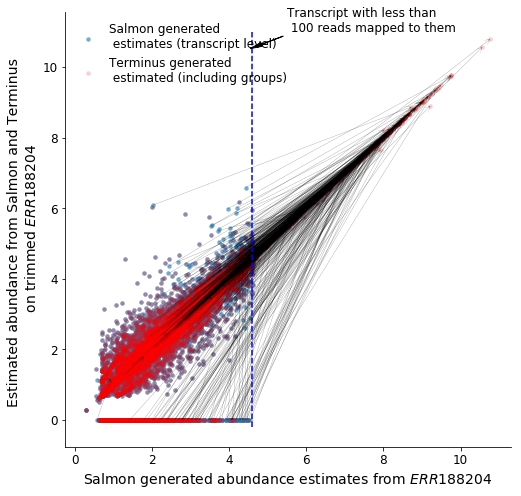

In [16]:
X_pos = df4.loc[df4.group_name.str.contains('NewTr')]['count_x'].values
Y_pos = df4.loc[df4.group_name.str.contains('NewTr')]['salmon'].values
X_direct = df4.loc[df4.group_name.str.contains('NewTr')]['count_y'].values
X_direct = X_direct - X_pos
Y_direct = df4.loc[df4.group_name.str.contains('NewTr')]['terminus'].values
Y_direct = Y_direct - Y_pos
plt.figure(figsize=(8, 8))

ax = sns.scatterplot(
    x = 'count_x',
    y = 'salmon',
    #hue = "group_status",
    data = df4,
    s=20,
    linewidth=0,
    alpha = 0.6,
    label = 'Salmon generated \n estimates (transcript level)'
)

ax = sns.scatterplot(
    x = 'count_y',
    y = 'terminus',
    data = df4,
    s=20,
    linewidth=0,
    alpha = 0.2,
    color = 'r',
    label = 'Terminus generated \n estimated (including groups)'
)


# fig, ax = plt.subplots()
q = ax.quiver(X_pos, Y_pos, X_direct, Y_direct, angles = 'xy', width = 0.0003,scale_units='xy',
              scale = 1,
              headwidth = 50,
              headlength = 50
             )
#plt.xlabel('Truth')
#plt.ylabel('Salmon (blue) & Terminus (Red)')
plt.ylabel('Estimated abundance from Salmon and Terminus \n on trimmed $ERR188204$',fontsize = 14)
plt.xlabel('Salmon generated abundance estimates from $ERR188204$',fontsize = 14)
plt.legend(frameon=False, loc ='upper left',fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.vlines(x=np.log(100),ymin=-0.2,ymax=11,linestyles ='dashed',color = 'b')

ax.annotate('Transcript with less than \n 100 reads mapped to them', xy=(4.5, 10.5), xytext=(5.5, 11.0),fontsize=12,
            arrowprops=dict(facecolor='black', shrink=0.05,width=0.1,headwidth=4.1),
            )
sns.despine()
#ax.quiverkey(q, X=0.3, Y=1.1, U=10)
plt.show()